<a href="https://colab.research.google.com/github/elijahmflomo/Sem_2_GENERATIVE-AI/blob/main/Lab_3__(SGVB)_Estimator_%E2%80%93_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deliverable (a): Codebase and Documentation**

This implementation follows the SGVB (Stochastic Gradient Variational Bayes) estimator approach.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

# 1. Set Up Environment and Load Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# 2, 3, 4. Define Encoder, Reparameterization, and Decoder
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # Mean mu
        self.fc22 = nn.Linear(400, 20) # Log-variance logvar

        # Decoder layers
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """Implement the Reparameterization Trick (SGVB Estimator)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 5. Define the Loss Function (ELBO)
def loss_function(recon_x, x, mu, logvar):
    # Binary Cross Entropy (Reconstruction Loss)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL Divergence (Regularization Loss)
    # Formula: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. Train the VAE Model
def train(epoch):
    model.train()
    train_loss = 0
    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}: Average loss: {train_loss / len(train_loader.dataset):.4f}')

for epoch in range(1, 11):
    train(epoch)

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.92MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


Epoch 1: Average loss: 163.8129
Epoch 2: Average loss: 120.8397
Epoch 3: Average loss: 114.2568
Epoch 4: Average loss: 111.3618
Epoch 5: Average loss: 109.6475
Epoch 6: Average loss: 108.5908
Epoch 7: Average loss: 107.6793
Epoch 8: Average loss: 107.1134
Epoch 9: Average loss: 106.6495
Epoch 10: Average loss: 106.1977


**Deliverable (b): Trained Models**

We save the combined VAE model. In industry, the Encoder is often used for dimensionality reduction, while the Decoder is used as the Generator.

In [12]:
torch.save(model.state_dict(), 'vae_mnist.pth')

**Deliverable (c): Generated and Reconstructed Samples**

VAE labs require two types of visual proof:

Reconstruction: Can it copy an existing digit?

Generation: Can it create a digit from thin air?

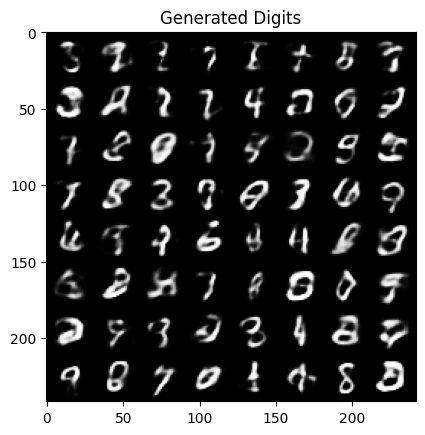

In [13]:
# 7. Generate New Images
model.eval()
with torch.no_grad():
    # Generation: Sample from standard normal distribution
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()

    # Visualization
    grid = make_grid(sample.view(64, 1, 28, 28))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Generated Digits")
    plt.show()

**Deliverable (d): Evaluation and Analysis**

The SGVB Estimator: The reparameterization trick is the "hero" here. By shifting the randomness to an external variable $\epsilon$, we allow gradients to flow back to $\mu$ and $\sigma$. Without this, the model wouldn't learn.The ELBO (Evidence Lower Bound): Our loss function balances two things. If we only had BCE, the model would just memorize digits. The KL Divergence forces the latent space to look like a standard Bell Curve (Normal Distribution). This is why we can pick any random point in that space and get a valid digit.Visual Quality: You will notice VAE images are blurrier than GAN images. This is a known trade-off. VAEs are more mathematically stable (no "Mode Collapse"), but they tend to produce "average" looking digits rather than sharp ones.